In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#import tensorflow as tf

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [11]:
from simulator2 import Simulator2, div2

In [12]:
def force2(m,n,p,w):
    f = np.zeros((m,n,p,3))
    f[5:-5,22:28,7:13,0] = 1 - w[5:-5,22:28,7:13,0]
    f += np.random.normal(size=(m,n,p,3))/3
    return f

def border_condition2(w):
    w[0,:,:,0] = 0
    w[-1,:,:,0] = 0
    w[:,0,:,1] = 0
    w[:,-1,:,1] = 0
    w[:,:,0,2] = 0
    w[:,:,-1,2] = 0

In [13]:
m,n,p = 40,50,20
sim = Simulator2(m,n,p,1,0.01, border_condition2, force2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
CPU times: user 3min 8s, sys: 7.1 s, total: 3min 15s
Wall time: 48.7 s


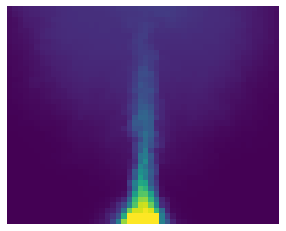

In [14]:
%%time

x = np.zeros((m,n,p))

def take_scalar(a,indices_i, indices_j, indices_k) :
    m,n,p = a.shape[:3]
    full_idices = p*(n*indices_i + indices_j) + indices_k
    reshaped = a.reshape(m*n*p)
    res = np.take(reshaped,full_idices, axis=0)
    return res.reshape(m,n,p)

def update_scalar(s,w,dt) :
    m,n,p = w.shape[:3]
    indices = np.indices((m,n,p)).swapaxes(0,1).swapaxes(1,2).swapaxes(2,3) - dt*w
    indices_floor = np.floor(indices).astype(np.int)
    frac = indices-indices_floor
    frac = [1-frac,frac]
    indices_ceil = indices_floor + 1
    indices_floor[:,:,:,0] = np.clip(indices_floor[:,:,:,0], 0, m-1)
    indices_ceil[:,:,:,0] = np.clip(indices_ceil[:,:,:,0], 0, m-1)
    indices_floor[:,:,:,1] = np.clip(indices_floor[:,:,:,1], 0, n-1)
    indices_ceil[:,:,:,1] = np.clip(indices_ceil[:,:,:,1], 0, n-1)
    indices_floor[:,:,:,2] = np.clip(indices_floor[:,:,:,2], 0, p-1)
    indices_ceil[:,:,:,2] = np.clip(indices_ceil[:,:,:,2], 0, p-1)
    indices = [indices_floor, indices_ceil] # shape : 2 m,n,p,3

    res = np.zeros((m,n,p))
    for i in range(2) :
        for j in range(2) :
            for k in range(2) :
                res += np.reshape(frac[i][:,:,:,0]*frac[j][:,:,:,1]*frac[k][:,:,:,2], (m,n,p)) * take_scalar(x, indices[i][:,:,:,0], indices[j][:,:,:,1], indices[k][:,:,:,2])
    res = res*1
    res[0:2,22:28,7:13] = 1
    return res

fig = plt.figure()
ims = []
for i in range(500) :
    dt=1
    sim.time_step(dt)
    x = update_scalar(x,sim.w,dt)
    x_proj = np.amax(x,-1)
    if not i % 10 :
        print(i)
    if not i % 3 :
        plt.axis('off')
        ims.append([plt.imshow(x_proj[::-1,:], animated=True)])

In [15]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())

In [14]:
import cProfile
def test_func() :
    for i in range(100) :
        sim.time_step(dt)
cProfile.run('test_func()', 'restats')

In [20]:
import pstats
p = pstats.Stats('restats')
p.sort_stats('cumulative').print_stats(50)

Tue Nov 19 15:51:09 2019    restats

         10829706 function calls (10739044 primitive calls) in 12.015 seconds

   Ordered by: cumulative time
   List reduced from 456 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.015   12.015 {built-in method builtins.exec}
        1    0.000    0.000   12.015   12.015 <string>:1(<module>)
        1    0.000    0.000   12.015   12.015 <ipython-input-14-79df4a85f0ea>:2(test_func)
      100    0.003    0.000   12.015    0.120 /Data/leo_h/stable-fluids/simulator.py:194(time_step)
      100    0.004    0.000   10.015    0.100 /Data/leo_h/stable-fluids/simulator.py:174(compute_w4)
      100    0.036    0.000    9.817    0.098 /Data/leo_h/stable-fluids/simulator.py:59(conjgrad_lap)
     3809    0.113    0.000    8.365    0.002 /Data/leo_h/stable-fluids/simulator.py:50(conjgrad_lap_step)
   154815    4.969    0.000    4.971    0.000 {built-in method _pywrap_tensorfl